# Niezbalansowana klasyfikacja

![image.png](attachment:image.png)

## Wstęp

Klasyfikacja obrazów to proces przypisywania etykiety do obrazu na podstawie jego zawartości. Przykładowo, chcielibyśmy, aby nasz program komputerowy mógł rozpoznawać, czy na obrazie jest kot, pies, samochód, samolot czy może coś zupełnie innego. W dzisiejszych czasach popularnym narzędziem do rozpoznawania obrazów są tzw. sieci konwolucyjne (CNN).

Sieci konwolucyjne są rodzajem sieci neuronowych, które potrafią analizować i rozpoznawać wzorce w danych wizualnych.

W przypadku klasyfikacji obrazów, sieć konwolucyjna składa się z kilku warstw, w tym konwolucyjnych i poolingowych. Warstwy konwolucyjne służą do ekstrakcji cech z obrazu, następnie za pomocą warstw poolingowych zmniejszamy wymiary danych, a na końcu wykorzystujemy warstwy w pełni połączone do klasyfikacji obrazu.

Progresywne zmniejszanie warstw pozwala sieciom rozpoznawać coraz to bardziej abstrakcyjne cechy jako złożenie wielu pomniejszych cech np. ptak to coś co ma dziób i jest opierzone. Dziób z kolei to np. ostry kształt o żółtawym kolorze a opierzenie oznacza pokrycie dużą ilością małych kresek.

### Zadanie

Zaimplementuj klasyfikator `YourCnnClassifier`, rozpoznający i klasyfikujący obrazki na dwie klasy. Powinna być to konwolucyjna sieć neuronowa napisana z użyciem pakietu `pytorch`.

Twoimi danymi w tym zadaniu są obrazki w formacie \*.jpg o wymiarze 224 x 224. Obrazki te dzielą się na dwie kategorie: *normal* oraz *onion*, którym przypisano odpowiednio etykiety 0 i 1.

Obrazki z klasy *normal* przedstawiają jasnoszare figury na czarnym tle. Natomiast obrazki z klasy *onion* różnią się tym, że mają dodane ciemnoszare pasma tworzące warstwy w środku jasnoszarych figur, co upodabnia je do cebuli. Wszystkie obrazki są dodatkowo zaszumione.

![image-3.png](attachment:image-3.png)
![image-2.png](attachment:image-2.png)

Publicznym interfejsem klasy `YourCnnClassifier` muszą być dwie metody ([class methods](https://stackoverflow.com/questions/12179271/meaning-of-classmethod-and-staticmethod-for-beginner) dokładnie rzecz biorąc):
- `load` - ma wczytać parametry modelu z pliku `cnn-classifier.pth`. Tego będziemy używać podczas testowania twojego rozwiązania
- `create_with_training` - ma wytrenować model i zapisać jego parametry do pliku `cnn-classifier.pth`.

### Kryterium oceny

Twoje rozwiązanie oceniane będzie na podstawie skuteczności klasyfikacji

$$
\mathrm{score}(accuracy) = \begin{cases}
    0 & \text{jeżeli } accuracy < 0.5 \\
    (accuracy - 0.5) * 2 & \text{w.p.p.}
\end{cases}
$$

Powyższe kryterium, klasa abstrakcyjna opisująca interfejs modelu oraz ładowanie danych, są zaimplementowane poniżej przez nas. Jednocześnie podany jest przykład trywialnego klasyfikatora, który zawsze twierdzi, że próbka jest normalna. Tym samym podczas testowania na zbalansowanym zbiorze testowym otrzymuje on 0 pkt.

### Pliki zgłoszeniowe

1. Ten notebook
2. Plik zawierający wagi modelu o nazwie `cnn-classifier.pth`

**Uwaga:** Zbiór danych treningowych, który dostarczamy, jest niezbalansowany, natomiast Twoje rozwiązanie testowane będzie na zbalansowanym zbiorze, aby metryka `accuracy` była miarodajna. Weź to pod uwagę podczas tworzenia swojego modelu.

### Ograniczenia

- Ewaluacja twojego rozwiązania (bez treningu, flaga `FINAL_EVALUATION_MODE` ustawiona na `True`) na 50 przykładach testowych powinna trwać nie dłużej niż 2 minuty na Google Colab **bez** GPU.
- Wykonanie skryptu na Google Colab **bez** GPU z flagą `FINAL_EVALUATION_MODE` ustawioną na `False` powinno wytrenować model i wygenerować plik z wagami w nie więcej niż 15 minut.
- Rozmiar pliku `cnn-classifier.pth` nie powienien przekroczyć 35MB.

## Ewaluacja

Pamiętaj, że podczas sprawdzania flaga `FINAL_EVALUATION_MODE` zostanie ustawiona na `True`. Za pomocą skryptu `validation_script.py` możesz upewnić się, że Twoje rozwiązanie zostanie prawidłowo wykonane na naszych serwerach oceniających.

Za to zadanie możesz zdobyć pomiędzy 0 i 1 punktów. Liczba punktów, które zdobędziesz będzie równa wartości `score`, wyliczonej na zbiorze testowym.

# Kod startowy

In [1]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

FINAL_EVALUATION_MODE = False
# W czasie sprawdzania Twojego rozwiązania, zmienimy tę wartość na True
# Wartość tej flagi M U S I zostać ustawiona na False w rozwiązaniu, które nam nadeślesz!

In [2]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

import abc
import os

import glob
import gdown
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import zipfile

## Ładowanie danych

In [3]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

GDRIVE_DATA = [
    ("1bR87z7ZI3gLK0vAGkyr_cnVGZ9P9bO7A", "train_data.zip"),
    ("1TA0lWnjJCv3lyRMML4JNHsJz3RJ-TUwZ", "valid_data.zip"),
]

def download_data():
    for file_id, zip_name in GDRIVE_DATA:
        folder_name = zip_name.split(".")[0]
        if not os.path.exists(folder_name):
            url = f'https://drive.google.com/uc?id={file_id}'
            gdown.download(url, output=zip_name, quiet=True)
            with zipfile.ZipFile(zip_name, 'r') as zip_ref:
                    zip_ref.extractall(folder_name)
            os.remove(zip_name)

download_data()

class ImageDataset(torch.utils.data.Dataset):
    """Implementacja abstrakcji zbioru danych z torch'a."""
    def __init__(self, dataset_type: str):
        self.filelist = glob.glob(f"{dataset_type}_data/*")
        self.labels   = [0 if "normal" in path else 1 for path in self.filelist]

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx) -> tuple[torch.Tensor, int]:
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = torchvision.transforms.functional.to_tensor(plt.imread(self.filelist[idx])[:,:,0])
        label = self.labels[idx]
        return image, label

    def loader(self, **kwargs) -> torch.utils.data.DataLoader:
        """
        Stwórz, `DataLoader`'a dla aktualnego zbioru danych.

        Wszystkie `**kwargs` zostaną przekazane do konstruktora `torch.utils.data.DataLoader`.
        `DataLoader`'y w skrócie to abstrakcja ładowania danych usdostępniająca wygodny interfejs.
        Możesz dowiedzieć się o nich więcej tutaj: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
        """
        return torch.utils.data.DataLoader(self, **kwargs, shuffle=True)

train_dataset: ImageDataset = ImageDataset("train")
valid_dataset: ImageDataset = ImageDataset("valid")

In [4]:
def shuffle_dataset(dataset):
    arr1 = np.array(dataset.filelist)
    arr2 = np.array(dataset.labels)

    combined_array = np.column_stack((arr1, arr2))

    np.random.seed(42)  # Set a seed for reproducibility, if desired
    np.random.shuffle(combined_array)

    array1 = np.array(dataset.filelist)
    array2 = np.array(dataset.labels)

    combined_array = np.column_stack((array1, array2))

    # Step 3: Split the shuffled array back into two arrays
    sa1 = combined_array[:, 0]
    sa2 = combined_array[:, 1]

    dataset.filelist = sa1.astype(str).tolist()
    dataset.labels = sa2.astype(int).tolist()

    return dataset

In [5]:
array1 = np.array(train_dataset.filelist)
array2 = np.array(train_dataset.labels)

combined_array2 = np.column_stack((array1, array2))

count_label_0 = np.sum(combined_array2[:, 1] == '0')

# If there are enough rows with label 0, remove 1000 rows with label 0
if count_label_0 >= 1000:
    print(np.where(combined_array2[:, 1] == '0')[0])

    indices_label_0 = np.where(combined_array2[:, 1] == '0')[0]

    # Randomly select 1000 indices to remove
    indices_to_remove = np.random.choice(indices_label_0, 1000, replace=False)

    # Remove rows with selected indices
    combined_array = np.delete(combined_array2, indices_to_remove, axis=0)

# Step 3: Split the shuffled array back into two arrays
x1 = combined_array[:, 0]
x2 = combined_array[:, 1]

train_dataset.filelist = x1.astype(str).tolist()
train_dataset.labels = x2.astype(int).tolist()

train_dataset = shuffle_dataset(train_dataset)


[   0    1    2 ... 1797 1798 1799]


In [6]:
print(train_dataset[0][1])

0


## Kod z kryterium oceniającym

In [7]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

def accuracy_to_points(accuracy: float) -> float:
    """Oblicz wynik na podstawie celności predykcji."""
    return (round(accuracy, 2) - 0.5) * 2 if accuracy > 0.5 else 0.0

def grade(model):
    """Oceń ile punktów otrzyma aktualne zadanie."""
    model.eval()
    test_loader = valid_dataset.loader()
    correct = 0
    total = 0
    with torch.no_grad():
        for [images, labels] in test_loader:
            outputs = model(images).squeeze()
            incorrect_indices = torch.where((outputs > 0.5).int() != labels)[0]
            correct += len(labels) - len(incorrect_indices)
            total += len(labels)
        accuracy = correct / total if total != 0 else 0
        if not FINAL_EVALUATION_MODE:
            print(f"Accuracy: {int(round(accuracy, 2) * 100)}%")
        return accuracy_to_points(accuracy)

## Publiczny interfejs rozwiązania

Tylko tego wymagamy od Twojej klasy, w Twoim rozwiązaniu możesz modyfikować swoją klasę do woli dodając nowe metody oraz atrybuty klasy - cokolwiek co będzie Ci potrzebne do rozwiązania zadania.

In [8]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

class CnnClassifier(torch.nn.Module, abc.ABC):
    MODEL_PATH: str = "cnn-classifier.pth"

    @classmethod
    def load(cls):
        """Załaduj model z pliku."""
        model = cls()
        model.load_state_dict(torch.load(cls.MODEL_PATH))
        return model


    @classmethod
    @abc.abstractmethod
    def create_with_training(cls):
        """Zapisz model do pliku."""
        pass

## Przykładowe rozwiązanie
Poniżej prezentujemy proste rozwiązanie, które w oczywisty sposób nie jest optymalne. Służy temu, aby było wiadomo w jaki sposób ma działać cały notatnik.

In [9]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

if not FINAL_EVALUATION_MODE:
    class DummyCnnClassifier(CnnClassifier):
        def forward(self, x):
            batch_size, *_ = x.shape
            return torch.zeros(batch_size)

        @classmethod
        def create_with_training(cls):
            return cls()

    dummy_model = DummyCnnClassifier.create_with_training()
    print(f"DummyCnnClassifier -- Ocena: {grade(dummy_model)} pkt")

    del dummy_model
    del DummyCnnClassifier

Accuracy: 50%
DummyCnnClassifier -- Ocena: 0.0 pkt


# Twoje Rozwiązanie

In [10]:
class YourCnnClassifier(CnnClassifier):
    def __init__(self):
        super(YourCnnClassifier, self).__init__()

        self.clear = nn.MaxPool2d(kernel_size=(4,4))

        self.first_conv = nn.Conv2d(1, 6, kernel_size=(4,4), stride=1)
            # nn.BatchNorm2d((6,43,43))
        self.first_pool = nn.MaxPool2d(kernel_size=(2,2))

        self.second_conv = nn.Conv2d(6, 12, kernel_size=(2,2), stride=1)
            # nn.BatchNorm2d(12,22,22)
        self.second_pool = nn.MaxPool2d(kernel_size=(2,2))

        self.first_linear = nn.Linear(12 * 12 * 12, 40)
        self.output_layer = nn.Linear(40, 1)


    def forward(self, x):
        c = self.clear(x)

        c = self.first_conv(c)
        c = self.first_pool(c)

        c = self.second_conv(c)
        c = self.second_pool(c)

        c = self.first_linear(c.flatten())
        c = self.output_layer(c)

        if not self.training:
            if torch.sigmoid(c)>0.5:
                return torch.tensor(1)
            else:
                return torch.tensor(0)


        return torch.sigmoid(c)

    @classmethod
    def create_with_training(cls):
        global train_dataset
        model = cls()

        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        epochs = 10

        for epoch in range(epochs):
            model.train()  # Set the model to training mode

            for inputs, labels in train_dataset:
                outputs = model(inputs)

                optimizer.zero_grad()

                # print("OUPT: " + str(outputs.squeeze()) + " // Labels: " + str(torch.tensor(labels).float()))

                loss = criterion(outputs.squeeze(), torch.tensor(labels).float())  # Squeeze to remove extra dimension

                loss.backward()
                optimizer.step()

                train_dataset = shuffle_dataset(train_dataset)

            print(f"Epoch [{epoch+1}/{epochs}] /// Loss [{loss.item()}]")

            # if sum(running_loss)/len(running_loss) < 0.01:
            #     print("Model have good enough accuracy. Training process has been finished.")
            #     torch.save(model.state_dict(), model.MODEL_PATH)
            #     return model

        torch.save(model.state_dict(), model.MODEL_PATH)
        return model

In [11]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

your_model = YourCnnClassifier.load() if FINAL_EVALUATION_MODE else YourCnnClassifier.create_with_training()

Epoch [1/10] /// Loss [0.023640058934688568]
Epoch [2/10] /// Loss [0.0015233188169077039]
Epoch [3/10] /// Loss [0.0003323771234136075]
Epoch [4/10] /// Loss [0.00011606245971051976]
Epoch [5/10] /// Loss [5.141268775332719e-05]
Epoch [6/10] /// Loss [2.56643834291026e-05]
Epoch [7/10] /// Loss [1.373857321596006e-05]
Epoch [8/10] /// Loss [7.781261047057342e-06]
Epoch [9/10] /// Loss [4.6690333874721546e-06]
Epoch [10/10] /// Loss [3.041528316316544e-06]


# Ewaluacja

In [12]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

def evaluate_model(model):
    """Oceń ile punktów otrzyma aktualne zadanie."""
    return grade(model)

In [13]:
def display(img_tensor):
    image_array = img_tensor.cpu().detach().numpy()

    # If your image is in CHW format (channels, height, width), transpose it to HWC
    # If your image is in HWC format, you can skip this step
    image_array = image_array.transpose(1, 2, 0)

    # Plot the image
    plt.imshow(image_array, cmap='gray')
    plt.show()

0
tensor(0)


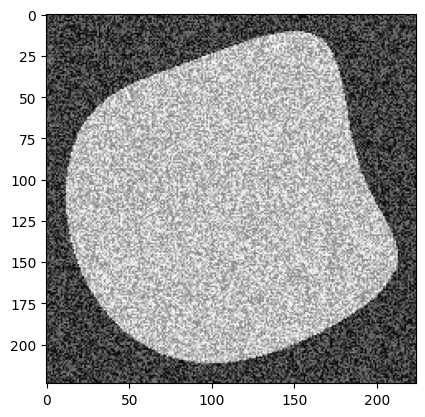

In [16]:
id = len(train_dataset)-10

print(train_dataset[id][1])
print(your_model(train_dataset[id][0]))
display(train_dataset[id][0])

In [15]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################

if not FINAL_EVALUATION_MODE:
    print(f"YourCnnClassifier -- Ocena: {evaluate_model(your_model):.2f} pkt")

Accuracy: 100%
YourCnnClassifier -- Ocena: 1.00 pkt
